# Kwadraty jednakowej wielkości

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from scipy import misc
import math

In [2]:
PATH = "../data/dataset/square/"
NAME = "train"

X = np.load(PATH + "%s_X.npy" % (NAME), mmap_mode="r")
Y_1 = np.load(PATH + "%s_Y_1.npy" % (NAME), mmap_mode="r")
Y_2 = np.load(PATH + "%s_Y_2.npy" % (NAME), mmap_mode="r")
Y_4 = np.load(PATH + "%s_Y_4.npy" % (NAME), mmap_mode="r")
Y_9 = np.load(PATH + "%s_Y_9.npy" % (NAME), mmap_mode="r")
Y_25 = np.load(PATH + "%s_Y_25.npy" % (NAME), mmap_mode="r")

In [3]:
INDEX = np.random.randint(0, X.shape[0])

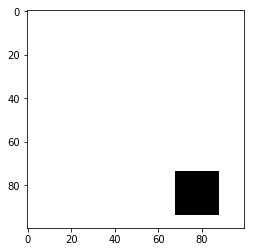

In [4]:
image = X[INDEX,:]
plt.imshow(image, cmap="gray")

In [6]:
print(Y_1[INDEX])
print(Y_2[INDEX])
print(Y_4[INDEX])
print(Y_9[INDEX])
print(Y_25[INDEX])

[0.78 0.84]
[1]
[3]
[8]
[23]


### Klasyfikacja na 2 części (czy w prawej czy w lewej połówce)
2 epoki - accuracy 100%
### Klasyfikacja na 4 części
2 epoki - accuracy 100%
### Klasyfikacja na 9 części
3 epoki - accuracy 100%
### Klasyfikacja na 25 części
2 epoki - accuracy 100%
### Regresja
46 epok - mse: 0.000452887 (błąd ~0.021 - przy 100x100 obrazku około 2px błędu)

# Regresja cd

In [7]:
NAME = "test"

X = np.load(PATH + "%s_X.npy" % (NAME), mmap_mode="r")
Y = np.load(PATH + "%s_Y_1.npy" % (NAME), mmap_mode="r")

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.python.tools import inspect_checkpoint as chkp

class ConvNetwork(object):
    def __init__(self, model_path):
        self.model_path = model_path
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.sess = tf.Session(graph=self.graph)
            saver = tf.train.import_meta_graph(model_path + ".meta")
            saver.restore(self.sess, model_path)

        self.y_conv = self.graph.get_tensor_by_name("fc2/y_conv:0")
        self.y = self.graph.get_tensor_by_name("y:0")
        self.x = self.graph.get_tensor_by_name("x:0")
        self.keep_prob = self.graph.get_tensor_by_name("dropout/keep_prob:0")
        self.loss = self.graph.get_tensor_by_name("loss/loss:0")

    def generate_args(self, x):
        return self.sess.run(self.y_conv, feed_dict={self.x: np.expand_dims(x, 0), self.keep_prob: 1.0})[0]

    def eval_error(self, X, Y):
        return self.loss.eval(session=self.sess, feed_dict={self.x: X, self.y: Y, self.keep_prob: 1.0})

    def print_tensors(self):
        chkp.print_tensors_in_checkpoint_file(self.model_path, tensor_name='', all_tensors=True)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
model_path = "../result/model/regression/regression-46"
cnn = ConvNetwork(model_path)

INFO:tensorflow:Restoring parameters from ../result/model/regression/regression-46


In [15]:
def show_square(index):
    image = X[index,:]
    plt.imshow(image, cmap="gray")
    print("True coordinates = " + str(Y[index]))

Predicted coordinates = [0.41666013 0.62648815]
True coordinates = [0.41 0.61]


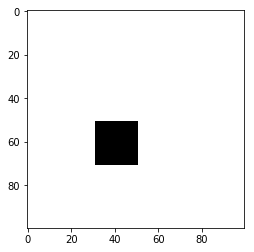

In [16]:
print("Predicted coordinates = " + str(cnn.generate_args(X[0])))
show_square(0)

In [17]:
Y_ = [cnn.generate_args(x) for x in X]

In [18]:
from tqdm import tqdm

In [19]:
def eval_mse():
    batch_size = 10
    num_batches = len(X) // batch_size
    mse = []
    for i in tqdm(range(num_batches)):
        start = i * batch_size
        end = start + batch_size
        mse.append(cnn.eval_error(X[start:end], Y[start:end]))
    print(np.mean(np.array(mse)))

In [20]:
eval_mse()

100%|██████████| 150/150 [02:04<00:00,  1.17it/s]

0.00045288965


Mse = 0.00045289 oznacza średni błąd ~0.0212812124 dla współrzędnych czyli około 2px dla obrazka 100x100. Zejście do mse < 0.0001 oznaczałoby nieznączacy błąd dla obrazka 100x100. Czyli chcąc uzyskać "idealne" wyniki trzeba osiągnąć $$mse < (\frac{1}{size})^2$$

# Predykcja argumentów do narysowania kwadratu

### Dane

In [21]:
name = "train"
path = "../data/dataset/square_with_parameters/"
image_size = 100

In [22]:
def to_255_color(x):
    return x * 255

def to_image_size(x):
    return x * image_size

def to_180_rotation(x):
    return (x - 0.5) * 360

def print_scaled_y(y):
    print("RGBA = (%d, %d, %d, %d), lewy górny róg = (%d, %d), w = %d, h = %d, rotation = %d" 
      % (to_255_color(y[0]), to_255_color(y[1]), to_255_color(y[2]), y[3] * 100, to_image_size(y[4]),
         to_image_size(y[5]), to_image_size(y[6]), to_image_size(y[7]), to_180_rotation(y[8])))
    
def show(i):
    print_scaled_y(Y[i])
    plt.imshow(X[i], cmap="gray")

In [24]:
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

RGBA = (0, 0, 0, 100), lewy górny róg = (1, 43), w = 47, h = 47, rotation = 0


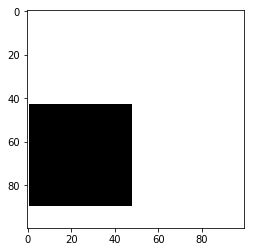

In [25]:
show(666)

### Model

--conv1_filters 16 --conv2_filters 32 --fc1_neurons 64 --learning_rate 0.001 --dropout 0.5 --batch_size 50 --fc2_sigmoid

In [30]:
model_path = "../result/model/square_arguments/square_arguments-1"
cnn = ConvNetwork(model_path)

INFO:tensorflow:Restoring parameters from ../result/model/square_arguments/square_arguments-1


In [31]:
name = "test"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

RGBA = (0, 0, 0, 100), lewy górny róg = (20, 34), w = 55, h = 55, rotation = 0


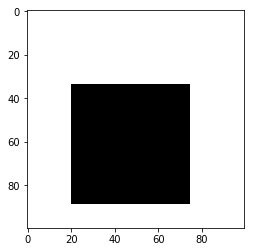

In [48]:
index = np.random.randint(0, X.shape[0])
show(index)

In [33]:
eval_mse()

100%|██████████| 150/150 [02:07<00:00,  1.17it/s]

0.026467793


In [38]:
import os
import matplotlib.image as mpimg

In [45]:
def draw(y_):
    path_to_image_results = '../result/gimp_images/nn/shapes'
    name = 'jupyter_test.png'
    os.system('python ../src/gimp/draw/draw_selection_shape.py --name {} --shape {} --size {} --r {} '
            '--g {} --b {} --a {} --x {} --y {} --w {} --h {} --rotation {}'.format(name, 'rectangle', 100, y_[0], y_[1], y_[2], y_[3], y_[4], y_[5], y_[6], y_[7], y_[8]))
    image_data = mpimg.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
    plt.imshow(image_data)

RGBA = (5, 0, 6, 96), lewy górny róg = (24, 28), w = 45, h = 45, rotation = -8


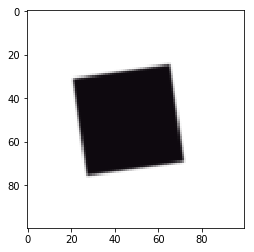

In [50]:
y_ = cnn.generate_args(X[index])
print_scaled_y(y_)
draw(y_)

Powyżej efekt dla jednej epoki (2 min uczenia). Całkiem spoko.

In [53]:
model_path = "../result/model/square_parameters/square_parameters-75"
cnn = ConvNetwork(model_path)

INFO:tensorflow:Restoring parameters from ../result/model/square_parameters/square_parameters-75


In [54]:
eval_mse()

100%|██████████| 150/150 [00:38<00:00,  4.01it/s]

0.00038302143


RGBA = (0, 0, 0, 99), lewy górny róg = (19, 34), w = 55, h = 55, rotation = 0


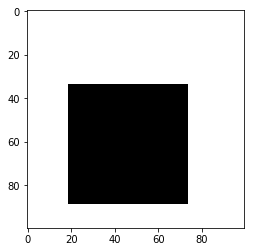

In [55]:
args = cnn.generate_args(X[index])
print_scaled_y(args)
draw(args)

RGBA = (0, 0, 0, 100), lewy górny róg = (43, 11), w = 55, h = 55, rotation = 0


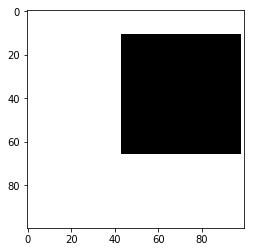

In [56]:
index = 444
show(index)

RGBA = (0, 0, 0, 99), lewy górny róg = (39, 7), w = 53, h = 53, rotation = 0


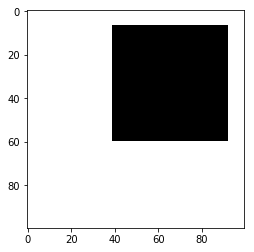

In [57]:
args = cnn.generate_args(X[index])
print_scaled_y(args)
draw(args)

RGBA = (0, 0, 0, 100), lewy górny róg = (16, 46), w = 15, h = 15, rotation = 0


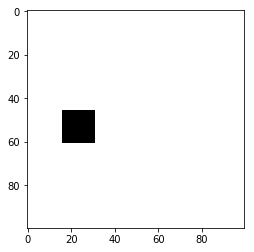

In [58]:
index = 100
show(index)

RGBA = (0, 0, 0, 99), lewy górny róg = (10, 45), w = 16, h = 16, rotation = 0


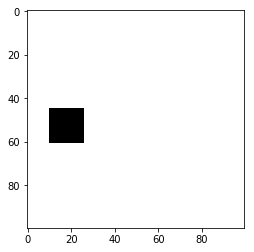

In [59]:
args = cnn.generate_args(X[index])
print_scaled_y(args)
draw(args)

Po 75 epokach model myli się trochę w położeniu i czasem delikatnie w wielkości kwadratu

# Predykcja argumentów do narysowania kwadratu - sieć widzi różnicę "pustego" obrazka z obrazkiem kwadratu

### Dane

In [63]:
name = "train"
path = "../data/dataset/diff_square_with_parameters/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

RGBA = (0, 0, 0, 100), lewy górny róg = (18, 10), w = 79, h = 79, rotation = 0


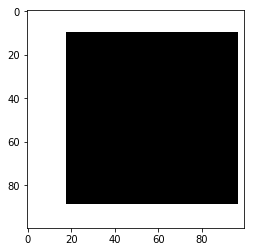

In [64]:
show(666)

In [65]:
print(X[666][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### Model


--conv1_filters 32 --conv2_filters 16 --fc1_neurons 64 --learning_rate 0.001 --dropout 0.5 --batch_size 100  --loss_sigmoid

In [69]:
model_path = "../result/model/square/diff_square_parameters/diff_square_parameters-95"
cnn = ConvNetwork(model_path)

INFO:tensorflow:Restoring parameters from ../result/model/square/diff_square_parameters/diff_square_parameters-95


In [70]:
name = "test"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

In [71]:
eval_mse()

100%|██████████| 150/150 [00:18<00:00,  7.99it/s]

0.000365371


In [72]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

RGBA = (0, 0, 0, 100), lewy górny róg = (3, 23), w = 44, h = 44, rotation = 0


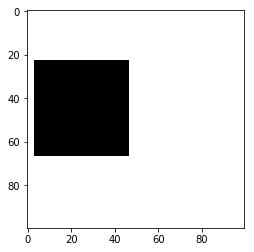

In [73]:
show(666)

RGBA = (0, 0, 0, 100), lewy górny róg = (1, 24), w = 43, h = 43, rotation = 0


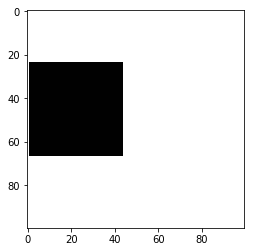

In [74]:
args = sigmoid(cnn.generate_args(X[666]))
print_scaled_y(args)
draw(args)

RGBA = (0, 0, 0, 100), lewy górny róg = (38, 6), w = 60, h = 60, rotation = 0


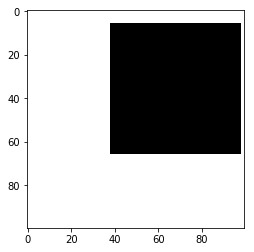

In [75]:
show(100)

RGBA = (0, 0, 0, 100), lewy górny róg = (35, 1), w = 61, h = 61, rotation = 0


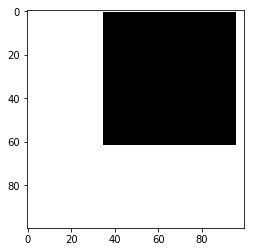

In [76]:
args = sigmoid(cnn.generate_args(X[100]))
print_scaled_y(args)
draw(args)

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ..., -0.99607843  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
RGBA = (0, 0, 0, 100), lewy górny róg = (6, 6), w = 92, h = 92, rotation = 0


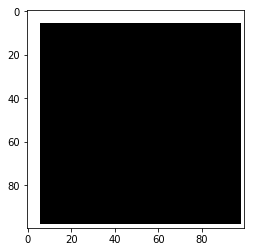

In [77]:
index = np.random.randint(0, X.shape[0])
print(X[index])
show(index)

RGBA = (0, 0, 0, 100), lewy górny róg = (0, 0), w = 93, h = 93, rotation = 0


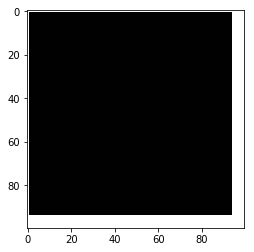

In [78]:
args = sigmoid(cnn.generate_args(X[index]))
print_scaled_y(args)
draw(args)

Czy taki model poradzi sobie jak zobaczy prostokąt/kilka prostokątów/kwadratów?

#### Test dla kwadrato podobnego obrazka

In [79]:
path_to_images = '../data/image'
def image_to_diff(path):
    image = plt.imread(path)
    flatten = np.sum(image, axis=2) / 3
    return flatten - np.ones((100, 100))

def diff_to_args(diff):
    args = cnn.generate_args(diff)
    return sigmoid(np.array(args, dtype=np.float128))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


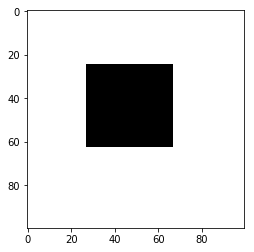

In [80]:
diff = image_to_diff('%s/%s' % (path_to_images, 'square.png'))
print(diff)
plt.imshow(diff, cmap='gray')

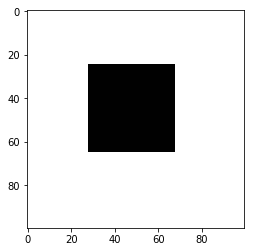

In [81]:
draw(diff_to_args(diff))

#### Test dla prostokąta

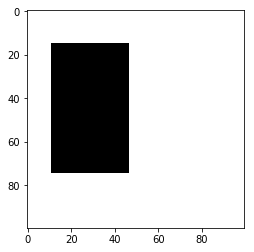

In [82]:
diff = image_to_diff('%s/%s' % (path_to_images, 'rectangle.png'))
plt.imshow(diff, cmap="gray")

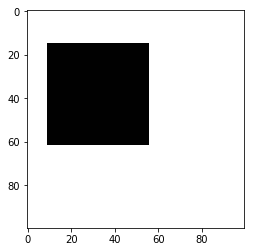

In [83]:
draw(diff_to_args(diff))

#### Test dla dwóch kwadrato podobnych prostokątów

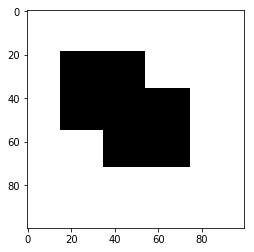

In [84]:
diff = image_to_diff('%s/%s' % (path_to_images, 'two_rectangles.png'))
plt.imshow(diff, cmap="gray")

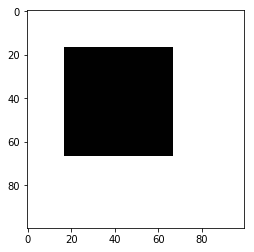

In [85]:
draw(diff_to_args(diff))

Wychodzi na to że ucząc się na samych kwadratach, siec jest w stanie rysować teraz jedynie kwadraty jak najlepiej wpasowujące się w dane miejsce

#### Test dla trzech kształtów odległych od siebie

0.0


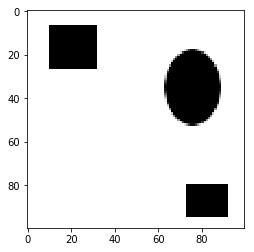

In [86]:
diff = image_to_diff('%s/%s' % (path_to_images, 'three_shapes.png'))
print(diff[0][0])
plt.imshow(diff, cmap="gray")

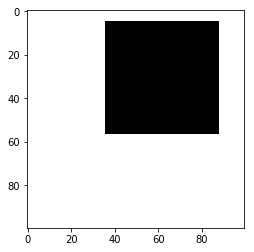

In [87]:
draw(diff_to_args(diff))

In [92]:
print(diff[50][65:75])

[ 0.         0.         0.         0.        -0.3843137 -1.        -1.        -1.
 -1.        -1.       ]


# Predykcja argumentów do narysowania losowego prostokątu z trzema kanałami - in progress

### Dane

In [66]:
name = "train"
path = "../data/dataset/diff_random_square_with_parameters/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

FileNotFoundError: [Errno 2] No such file or directory: '../data/dataset/diff_random_square_with_parameters/train_X.npy'

In [101]:
def show_diff(i):
    plt.imshow(X[i])
    
def show_source(i):
    plt.imshow(np.ones(X[i].shape) - X[i])

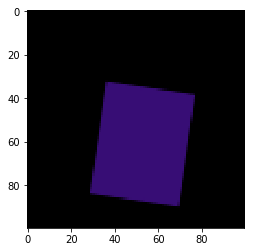

In [182]:
index = np.random.randint(0, X.shape[0])
show_diff(index)

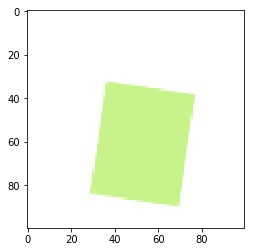

In [183]:
show_source(index)

In [ ]:
print()